In [1]:
%load_ext autoreload
%autoreload 2

import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent))

# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from src.data_utils import *
from src.cnnlstm import CNNLSTMModel
from src.training_utils import *

### Load segmented data

In [2]:
# define data directory
data_dir = '../data/'

In [3]:
# load data
data = load_data(data_dir)

# split data
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data)

Number of samples: 13388
--------------------
Train data shape: (10710, 100, 12)
Validation data shape: (1338, 100, 12)
Test data shape: (1340, 100, 12)
--------------------
X_train shape: (10710, 100, 3)
y_train shape: (10710, 100, 9)
X_val shape: (1338, 100, 3)
y_val shape: (1338, 100, 9)
X_test shape: (1340, 100, 3)
y_test shape: (1340, 100, 9)


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Achilles Tendon Force Across Training Samples'}, xlabel='Percent Normalized Stance (%)', ylabel='Muscle Force (N)'>)

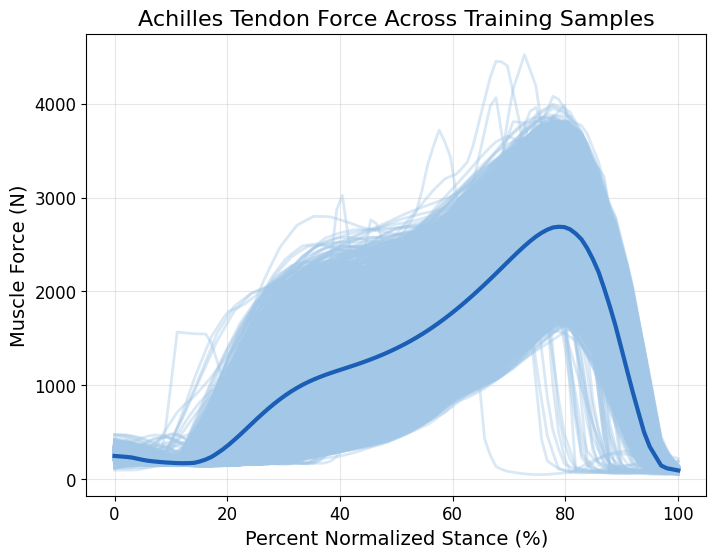

In [4]:
# plot data to double check
plot_achilles_force(y_train)

### Initialize model

In [5]:
# model parameters
input_size = 3  # grf features (x, y, z)
hidden_size = 64  # hidden size for LSTM (tunable)
num_layers = 2  # number of LSTM layers
output_size = 9  # muscle force features

# create the model
model = CNNLSTMModel(input_size, hidden_size, num_layers, output_size)

In [6]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [7]:
# move the model to the device
model.to(device)

CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=9, bias=True)
)

### Initialize hyperparameters and data loaders

In [8]:
# hyperparameters
num_epochs = 1000
learning_rate = 1e-3
batch_size = 32

# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# create dataloaders from datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

### Train model

In [ ]:
best_model, best_val, train_hist = train_model(model, train_loader, val_loader, num_epochs=num_epochs, learning_rate=learning_rate, patience=10)

Epoch [1/1000], Train Loss: 264260.6166, Val Loss: 260377.3176
Epoch [10/1000], Train Loss: 209680.0298, Val Loss: 207612.2787
Epoch [20/1000], Train Loss: 165348.4754, Val Loss: 163784.5503
Epoch [30/1000], Train Loss: 128859.0717, Val Loss: 127685.6875
Epoch [40/1000], Train Loss: 98854.5261, Val Loss: 97890.5179
Epoch [50/1000], Train Loss: 74357.4648, Val Loss: 73658.3425
Epoch [60/1000], Train Loss: 54977.1406, Val Loss: 54534.1608
Epoch [70/1000], Train Loss: 39730.6034, Val Loss: 39302.7481
Epoch [80/1000], Train Loss: 28149.4987, Val Loss: 27879.8008
Epoch [90/1000], Train Loss: 19698.0019, Val Loss: 19403.1048
Epoch [100/1000], Train Loss: 13502.4489, Val Loss: 13658.0763
Epoch [110/1000], Train Loss: 9278.6423, Val Loss: 9362.3082
Epoch [120/1000], Train Loss: 6522.6380, Val Loss: 6541.6136
Epoch [130/1000], Train Loss: 4800.5042, Val Loss: 4855.0053
Epoch [140/1000], Train Loss: 3913.9138, Val Loss: 3977.3713
Epoch [150/1000], Train Loss: 3359.9794, Val Loss: 3410.1633
Epoch

### Test model

In [10]:
test_loss, test_outputs, y_test_tensor = evaluate_model(best_model, X_test, y_test, device=device)

Test Loss: 3359.1272


### Plot sample prediction

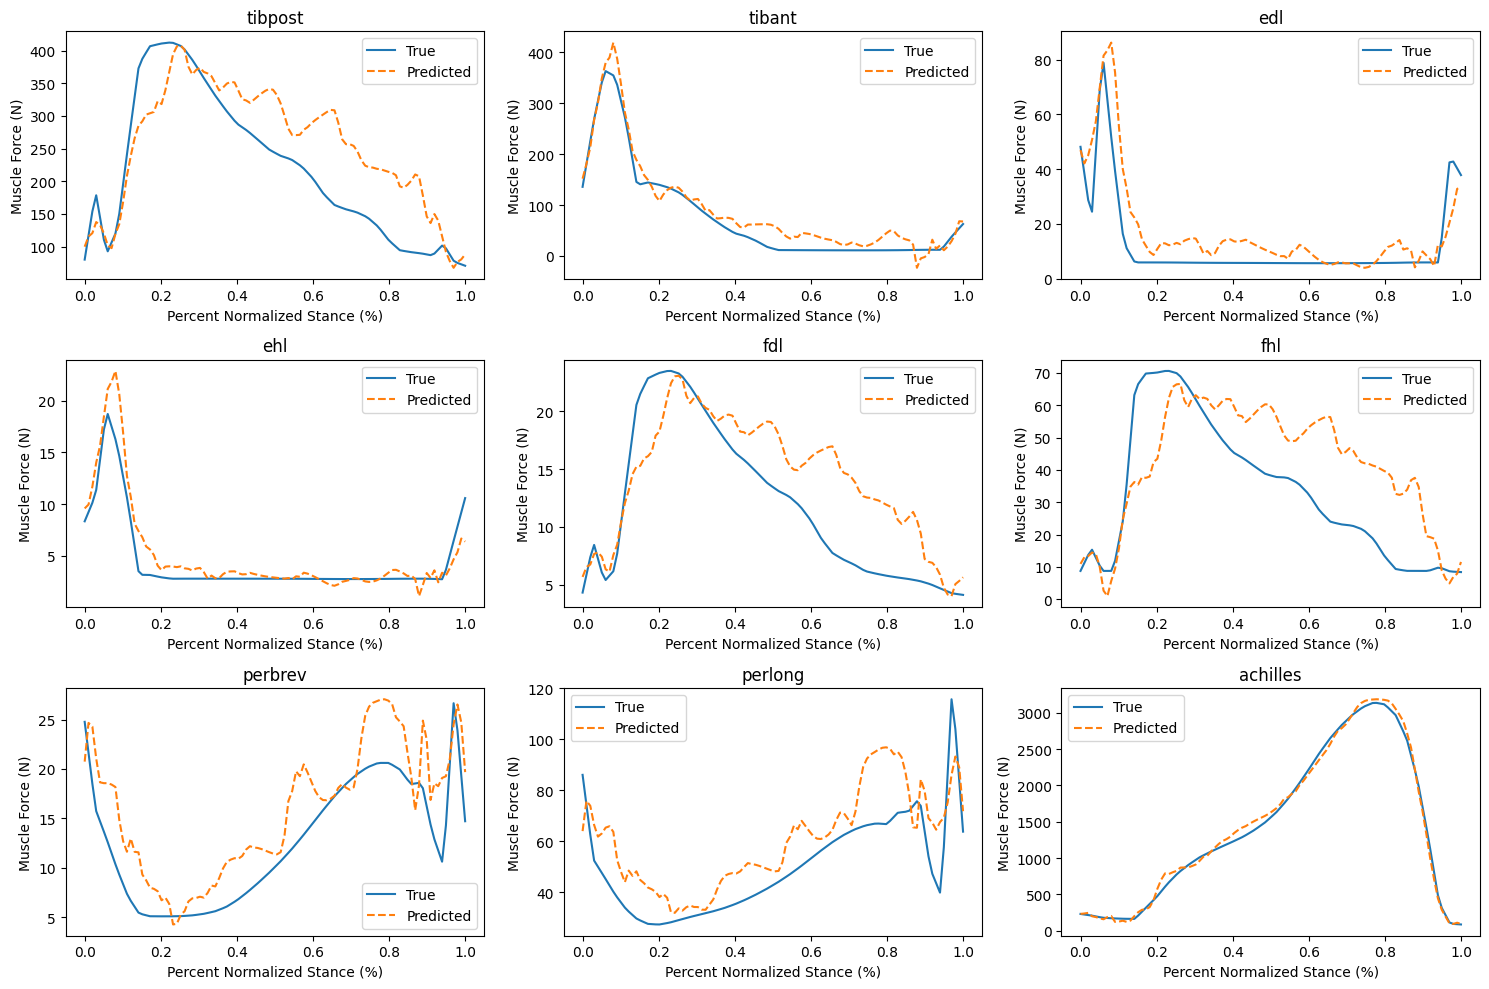

In [11]:
plot_preds(test_outputs, y_test_tensor, sample_idx=0)